# Рекомендательные системы



## О задании

В этой работе будем решать задачу рекомендации музыки. Поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты.



In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


## Метрика

Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

In [ ]:
def apk(relevant: List[int], predicted: List[int], k: int) -> float:
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20) -> float:
    return sum(apk(r, p, k) for r, p in zip(relevant, predicted)) / len(relevant)


## Подготовка данных

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

## Base model

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user_id in range(self.n_users):
            recommended = self.recommend(user_id)
            already_listened = self.ratings[self.ratings['userId'] == user_id]['trackId'].values
            filtered_rec = [track for track in recommended if track not in already_listened]
            test_preds.append(filtered_rec[:k])

        return test_preds

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

In [ ]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.sum((ratings * user_vector), axis = 1)
    union = np.sum((ratings + user_vector) > 0, axis = 1)
    union[union == 0] = 1e-9 #избегаем деления на ноль
    return intersection / union

Реализуем методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        s = self.similarity_func(self.R, user_vector)
        return s

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        s = self.similarity(user_vector)
        neighbors = np.where(s>self.alpha)[0]
        neighbors = neighbors[neighbors != uid]
        a = np.dot(s[neighbors], self.R[neighbors])
        b = np.sum(np.abs(s[neighbors]))
        if b == 0.0:
            b = 1e-9
        return np.argsort(a/b)[::-1]

Построим график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравним его с рекомендициями самых популярных треков и случайных.

In [ ]:
import random
k_values = list(range(1, 25, 3))
results = {
    'Jaccard': [],
    'Popular': [],
    'Random': []
}

jaccard_model = User2User(train_ratings, similarity_func=jaccard)
track_counts = train_ratings['trackId'].value_counts()

# Оцениваем модели
for k in tqdm(k_values):
    jaccard_recommendations = jaccard_model.get_test_recommendations(k)

    top_tracks = track_counts.head(k)
    popular_recommendations = [list(top_tracks.index) for _ in range(len(jaccard_recommendations))]

    random_recommendations = [[random.sample(list(train_ratings['trackId'].unique()), k) for e in range(len(jaccard_recommendations))]]

    mapk_jaccard = mapk(test_relevant, jaccard_recommendations, k)
    mapk_popular = mapk(test_relevant, popular_recommendations, k)
    mapk_random = mapk(relevant, random_recommendations, k)

    results['Jaccard'].append(mapk_jaccard)
    results['Popular'].append(mapk_popular)
    results['Random'].append(mapk_random)


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results

{'Jaccard': [0.0,
  0.0016843971631205672,
  0.001237516283108988,
  0.0010624788922661264,
  0.0009040840955734573,
  0.0008187881858094623,
  0.0007469607001917125,
  0.0006812704958113991],
 'Popular': [0.0,
  0.00026595744680851064,
  0.0001519756838905775,
  0.00010638297872340427,
  0.00040229819280555786,
  0.0004218520840861266,
  0.000539684937945922,
  0.0005012594641676449],
 'Random': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

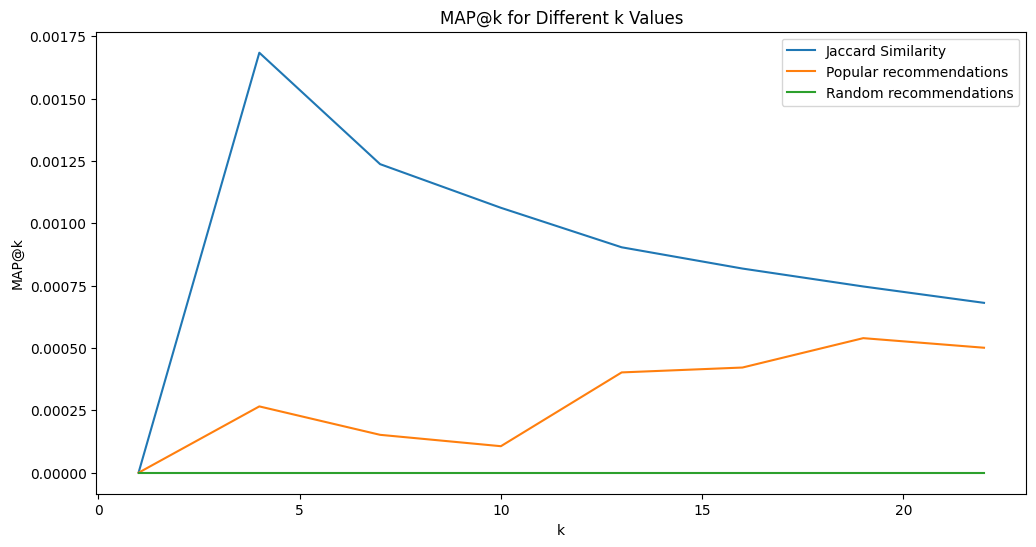

In [ ]:
# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(k_values, results['Jaccard'], label='Jaccard Similarity')
plt.plot(k_values, results['Popular'], label='Popular recommendations')
plt.plot(k_values, results['Random'], label='Random recommendations')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different k Values')
plt.legend();

**Вывод**: самым лучшим способом рекомендации оказался способ на основе меры Жаккара, при котором с увеличением k MAP@k уменьшается. Если рассматривать способ рекомендации, основанный на использовании популярных треков, то с ростом k увеличивается и метрика. Рандомные рекомендации всегда оказывались мимо, MAP@k находится стабильно на нулевом уровне.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя.

In [ ]:
model = User2User(train_ratings, similarity_func=jaccard)

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
177,Paper Planes,['M.I.A.']
269,Scars,['Papa Roach']
344,Somebody Told Me,['The Killers']
374,The Adventure,['Angels & Airwaves']
419,The Real Slim Shady,['Eminem']
421,Lose Yourself,['Eminem']
422,Stan,"['Eminem', 'Dido']"
427,My Name Is,['Eminem']
556,All These Things That I've Done,['The Killers']
557,Personal Jesus,['Marilyn Manson']


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2814,Numb,['Linkin Park']
805,Zombie,['The Cranberries']
2555,Californication,['Red Hot Chili Peppers']
164,My Favourite Game,['The Cardigans']
1019,It's My Life,['Bon Jovi']
26784,Shut Your Mouth,['Pain']
3106,Can't Stop,['Red Hot Chili Peppers']
7533,Highway to Hell,['AC/DC']
7286,Aerials,['System of A Down']
4464,Boulevard of Broken Dreams,['Green Day']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
37322,Legends Never Die,"['League of Legends', 'Against the Current']"
37369,Возможно,['Мы']
37462,Pull Up,['FACE']
37724,Live Outside,['Enter Shikari']
38604,The Inscriptions,['TRITIA']
38713,Плачу на техно,['ХЛЕБ']
39029,Lolly Bomb,['Little Big']
39185,Pussy Money Weed,['Tommy Cash']
39189,Major System Error,['Marmozets']
39809,Spotlight,"['Marshmello', 'Lil Peep']"


**Вывод**: получилось плохо

### Часть 2. Модель со скрытыми переменными: ALS

Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.


**LFM:**

$$
e_{ui} = r_{ui} - \hat{r}_{ui} = r_{ui} - \langle p_u, q_i \rangle
$$

$$
p_u \leftarrow p_u + \alpha (e_{ui} q_i - \lambda p_u)
$$

$$
q_i \leftarrow q_i + \alpha (e_{ui} p_u - \lambda q_i)
$$
**ALS:**

$$
p_u = (Q^T \Lambda_u Q + \lambda I)^{-1} Q^T \Lambda_u r_u
$$

$$q_i = (P^T \Lambda_i P + \lambda I)^{-1} P^T \Lambda_i r_i
$$

$\Lambda_u$— диагональная матрица, в которой элемент $\lambda_{ii}$ равен 1, если известен $r_{ui}$, и 0 в противном случае

$\Lambda_i$— диагональная матрица, в которой элемент $\lambda_{uu}$ равен 1, если известен $r_{ui}$, и 0 в противном случае


Реализуем методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for u in range(self.n_users):
                    for i in range(self.n_items):
                        if self.R[u,i]>0:
                            pred = np.dot(self.P[u, :], self.Q[i, :].T)
                            error = self.R[u,i] - pred
                            self.P[u, :] += self.lr*(error * self.Q[i, :] - self.lamb*self.P[u, :])
                            self.Q[i, :] += self.lr*(error * self.P[u, :] - self.lamb*self.Q[i, :])

            elif self.mode == 'als':

                for i in range(self.n_items):
                    self.Q[i] = np.linalg.solve(np.dot(self.P.T, self.P) + self.lamb * np.eye(self.dim),
                                                np.dot(self.P.T, self.R[:, i]))
                for u in range(self.n_users):
                    self.P[u] = np.linalg.solve(np.dot(self.Q.T, self.Q) + self.lamb * np.eye(self.dim),
                                                np.dot(self.Q.T, self.R[u, :]))


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

Для обоих алгоритмов подберем оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$.


In [ ]:
param_grid_sgd = [
    {'dim': 64, 'k': 5, 'mode': 'sgd'},
    {'dim': 100, 'k': 5, 'mode': 'sgd'},
    {'dim': 128, 'k': 5, 'mode': 'sgd'},
    {'dim': 256, 'k': 5, 'mode': 'sgd'},
    {'dim': 100, 'k': 10, 'mode': 'sgd'},
    {'dim': 128, 'k': 10, 'mode': 'sgd'}

]

best_metric_sgd = 0.0
best_params_sgd = None

for dictionary in tqdm(param_grid_sgd):
    model_sgd = LatentFactorModel(train_ratings, mode = 'sgd', dim = dictionary['dim'])
    model_sgd.fit(num_iters=5)
    recommendations = model_sgd.get_test_recommendations(dictionary['k'])
    score = mapk(test_relevant, recommendations, dictionary['k'])

    if score > best_metric_sgd:
        best_metric_sgd = score
        best_params_sgd = dictionary

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
best_metric_sgd, best_params_sgd

(0.00042553191489361707, {'dim': 64, 'k': 5, 'mode': 'sgd'})

In [ ]:
param_grid_als = [
    {'dim': 64, 'k': 5, 'mode': 'als'},
    {'dim': 100, 'k': 5, 'mode': 'als'},
    {'dim': 128, 'k': 5, 'mode': 'als'},
    {'dim': 256, 'k': 5, 'mode': 'als'},
    {'dim': 100, 'k': 10, 'mode': 'als'},
    {'dim': 128, 'k': 10, 'mode': 'als'}

]

best_metric_als = 0.0
best_params_als = None
for dictionary in tqdm(param_grid_als):
    model_als = LatentFactorModel(train_ratings, mode = 'als', dim = dictionary['dim'])
    model_als.fit(num_iters=5)
    recommendations = model_als.get_test_recommendations(dictionary['k'])
    score = mapk(test_relevant, recommendations, dictionary['k'])

    if score>best_metric_als:
        best_metric_als = score
        best_params_als = dictionary

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
best_metric_als, best_params_als

(0.0014052684903748732, {'dim': 128, 'k': 10, 'mode': 'als'})

In [ ]:
mapk_scores_sgd = []
mapk_scores_als = []
model_sgd = LatentFactorModel(train_ratings, mode = 'sgd', dim = best_params_sgd['dim'])
model_als = LatentFactorModel(train_ratings, mode = 'als', dim = best_params_als['dim'])
num_iters = 5

for iter in tqdm(range(1, num_iters + 1)):

      model_sgd.fit(num_iters=iter)
      model_als.fit(num_iters=iter)

      recommendations_sgd = model.get_test_recommendations(best_params_sgd['k'])
      recommendations_als = model.get_test_recommendations(best_params_als['k'])

      mapk_score_sgd = mapk(test_relevant, recommendations_sgd, best_params_sgd['k'])
      mapk_score_als = mapk(test_relevant, recommendations_als, best_params_als['k'])

      mapk_scores_sgd.append(mapk_score_sgd)
      mapk_scores_als.append(mapk_score_als)


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(mapk_scores_sgd) + 1), mapk_scores_sgd, label='sgd')
plt.plot(range(1, len(mapk_scores_als) + 1), mapk_scores_als, label='als')

plt.xlabel('Number of Iterations')
plt.ylabel('MAP@k')
plt.title('MAP@k for iteration')
plt.legend();

In [ ]:
sgd_list = []
als_list = []
for k in tqdm(k_values):

    sgd_recommendations = model_sgd.get_test_recommendations(k)
    als_recommendations = model_als.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, sgd_recommendations, k)
    mapk_als = mapk(test_relevant, als_recommendations, k)

    sgd_list.append(mapk_sgd)
    als_list.append(mapk_als)


  0%|          | 0/8 [00:00<?, ?it/s]

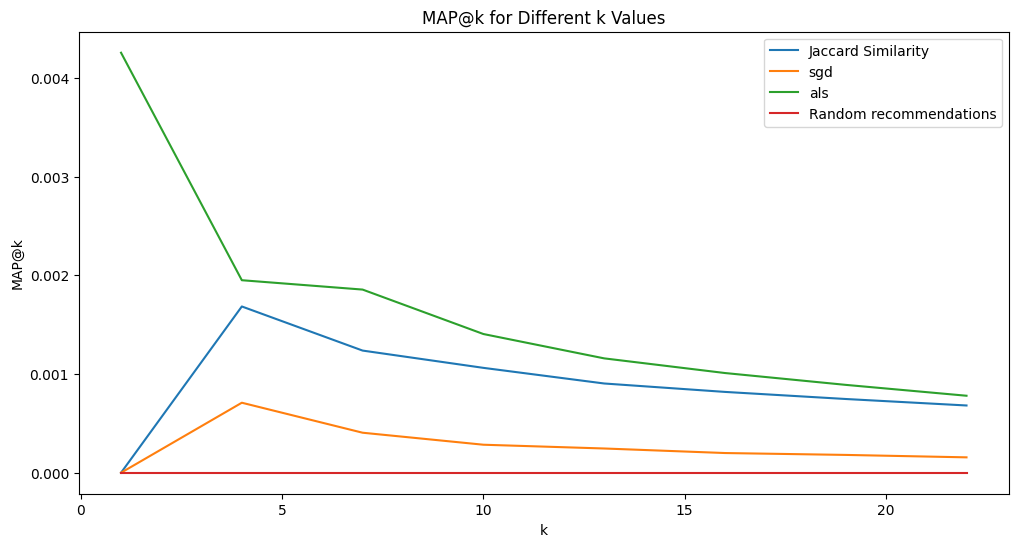

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, results['Jaccard'], label='Jaccard Similarity')
plt.plot(k_values, sgd_list, label='sgd')
plt.plot(k_values, als_list, label='als')
plt.plot(k_values, results['Random'], label='Random recommendations')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for Different k Values')
plt.legend();

In [ ]:
als_list

[0.00425531914893617,
 0.001950354609929078,
 0.00185555073093067,
 0.0014052684903748732,
 0.0011586122551752668,
 0.0010100781310887694,
 0.000890115198461157,
 0.0007799421410184864]

**Вывод**: ALS показал лучшие результаты

 Попробуем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
model_hidden = LatentFactorModel(train_ratings, mode = 'als', dim = best_params_als['dim'])

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model_hidden.Q @ model_hidden.Q[example_trackId]
preds = preds / np.sqrt((model_hidden.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_hidden.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
36420,Balearic Bliss,"['Steen Thøttrup', 'Denver Knoesen', 'Anders P...",0.286358
19725,Time in a Bottle,['Jim Croce'],0.282564
65084,Valhalla Calling,['Peyton Parrish'],0.259490
27918,График,['Несчастный Случай'],0.258987
15009,Funeralopolis,['Electric Wizard'],0.244944
50258,Бля буду,['Scrash'],0.243582
12258,Starships,['Nicki Minaj'],0.243475
11620,When We Stand Together,['Nickelback'],0.238990
59415,Looking For Me,"['Paul Woolford', 'Diplo', 'Kareen Lomax']",0.237370
